# Reduccion del computo redundante
Para la reduccion del computo redudante, es decir, evitar calculos repetitivos se puede hacer uso del decorador `@lru_cache`.

## ¡Cuidado!
Para poder usar este decorador, la funcion que lo use debe de ser idempotente o determinaste, basicamente develover siempre el mismo resultado dados los mismos argumentos.

El decorador `@lru_cache` guarda en memoria los resultados de llamadas anteriores a una funcion. Al llamar a esa funcion nuevamente, con los mismos argumentos, se devuelve el resultado previamente alamcenado por el decorador.

```mermaid
sequenceDiagram
    participant Usuario
    participant FunciónDecorada
    participant CacheLRU

    Usuario->>FunciónDecorada: Llama a función con argumentos (x)
    FunciónDecorada->>CacheLRU: ¿Está (x) en cache?
    alt Cache HIT
        CacheLRU-->>FunciónDecorada: Devuelve resultado de cache
        FunciónDecorada-->>Usuario: Retorna resultado cacheado
    else Cache MISS
        FunciónDecorada->>FunciónOriginal: Ejecuta con argumentos (x)
        FunciónOriginal-->>FunciónDecorada: Devuelve resultado
        FunciónDecorada->>CacheLRU: Guarda resultado en cache con clave (x)
        FunciónDecorada-->>Usuario: Retorna resultado calculado
    end
```

Al llamar a la funcion decorada, primero se consulta si el resultado ya esta en cache. Si asi es (cache HIT), se devuelve directamente. Si no (cache MISS), la funcion se ejecuta, y su resultado se guarda en cache para proximas llamadas con los mismos argumentos.

## Un ejemplo practico
Ahora veremos un ejemplo funcional. A continuación, se presenta información de algunos logs (eventos ocurridos en un pipeline de datos). Estos logs serán almacenados en una estructura de datos llamada árbol. Luego, realizaremos consultas al árbol para obtener todos los logs que se encuentren dentro de un rango de fechas específico, utilizando `@lru_cache` para guardar en memoria los resultados de estas consultas por intervalo de fechas, evitando así recalcular los mismos datos en futuras búsquedas.

In [1]:
from datetime import datetime, timedelta
import random
from functools import lru_cache
from typing import Callable
from time import time

from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

In [2]:
LOGS_STORE: SortedDict = SortedDict()

LOGS_STORE[datetime(2025, 4, 21, 14, 0)] = ("ERROR", "Base de datos caída")
LOGS_STORE[datetime(2025, 4, 21, 14, 5)] = ("INFO", "Servicio reiniciado")
LOGS_STORE[datetime(2025, 4, 21, 14, 10)] = ("MESSG", "Nuevo mensaje recibido en cola")
LOGS_STORE[datetime(2025, 4, 21, 14, 15)] = ("INFO", "Inicio de etapa de extracción")
LOGS_STORE[datetime(2025, 4, 21, 14, 20)] = ("INFO", "Fin de extracción y validación")
LOGS_STORE[datetime(2025, 4, 21, 14, 25)] = ("MESSG", "Datos cargados al almacenamiento")
LOGS_STORE[datetime(2025, 4, 22, 9, 0)] = ("INFO", "Ejecución automática iniciada")
LOGS_STORE[datetime(2025, 4, 22, 9, 5)] = ("ERROR", "Fallo en transformación de datos")
LOGS_STORE[datetime(2025, 4, 22, 9, 10)] = ("INFO", "Reintento de tarea fallida")
LOGS_STORE[datetime(2025, 4, 23, 8, 30)] = ("INFO", "Pipeline ejecutado exitosamente")
LOGS_STORE[datetime(2025, 4, 23, 8, 35)] = ("MESSG", "Correo de notificación enviado")
LOGS_STORE[datetime(2025, 4, 23, 8, 40)] = ("INFO", "Monitoreo finalizado sin errores")

In [3]:
def get_logs_between(start: datetime, end: datetime) -> list[tuple[str, str]]:
    """Obtiene todos los logs ocurridos entre dos fechas dadas.

    Args:
        start (datetime): Fecha y hora inicial desde donde buscar (inclusiva)
        end (datetime): Fecha y hora final hasta donde buscar (inclusiva)

    Returns:
        list[tuple[str, str]]: Una lista de tuplas donde cada tupla contiene:
            - Primer elemento (str): El nivel del log (ERROR, INFO, MESSG)
            - Segundo elemento (str): El mensaje descriptivo del log

    Ejemplo:
        >>> start = datetime(2025, 4, 21, 14, 0)
        >>> end = datetime(2025, 4, 21, 14, 10)
        >>> get_logs_between(start, end)
        [('ERROR', 'Base de datos caída'),
         ('INFO', 'Servicio reiniciado'),
         ('MESSG', 'Nuevo mensaje recibido en cola')]
    """
    return [
        LOGS_STORE[time_range]
        for time_range in LOGS_STORE.irange(start, end, inclusive=(True, True))
    ]
    
@lru_cache(maxsize=None)
def get_logs_between_cache(start: datetime, end: datetime) -> list[tuple[str, str]]:
    """Versión en caché de get_logs_between que almacena resultados en memoria.

    Esta función utiliza LRU cache para almacenar resultados previos y retornarlos
    inmediatamente si se solicita el mismo rango de fechas nuevamente, evitando
    cálculos redundantes.

    Args:
        start (datetime): Fecha y hora inicial desde donde buscar (inclusiva)
        end (datetime): Fecha y hora final hasta donde buscar (inclusiva)

    Returns:
        list[tuple[str, str]]: Una lista de tuplas donde cada tupla contiene:
            - Primer elemento (str): El nivel del log (ERROR, INFO, MESSG)
            - Segundo elemento (str): El mensaje descriptivo del log

    Nota:
        Esta función usa un tamaño de caché ilimitado (maxsize=None). Considere
        establecer un tamaño máximo si el uso de memoria es una preocupación.
    """
    return get_logs_between(start, end)

In [4]:
get_logs_between(datetime(2025, 4, 21, 14, 0), datetime(2025, 4, 22, 9, 10))  # ejemplo de uso

[('ERROR', 'Base de datos caída'),
 ('INFO', 'Servicio reiniciado'),
 ('MESSG', 'Nuevo mensaje recibido en cola'),
 ('INFO', 'Inicio de etapa de extracción'),
 ('INFO', 'Fin de extracción y validación'),
 ('MESSG', 'Datos cargados al almacenamiento'),
 ('INFO', 'Ejecución automática iniciada'),
 ('ERROR', 'Fallo en transformación de datos'),
 ('INFO', 'Reintento de tarea fallida')]

Ahora compararemos los tiempos de ejecucion tomados por 2 funciones: Consulta de todos los logs entre dos fechas dadas con y sin `@lru_cache`, en 2 escenarios diferentes: Con el mismo rango de fechas en cada llamado a la funcion, con un rango de fechas distinto en cada llamado a la funcion.  

In [5]:
def generate_random_dates(start_range: datetime, end_range: datetime) -> tuple[datetime, datetime]:
    """Genera un par de fechas aleatorias dentro de un rango dado.

    Args:
        start_range (datetime): Fecha inicial del rango desde donde generar fechas aleatorias
        end_range (datetime): Fecha final del rango hasta donde generar fechas aleatorias

    Returns:
        tuple[datetime, datetime]: Una tupla que contiene:
            - Primer elemento: Fecha de inicio aleatoria
            - Segundo elemento: Fecha de fin aleatoria (siempre posterior a la fecha de inicio)
            
    Example:
        >>> start = datetime(2025, 4, 1)
        >>> end = datetime(2025, 4, 30)
        >>> date_start, date_end = generate_random_dates(start, end)
        >>> print(f"Fecha inicio: {date_start}, Fecha fin: {date_end}")
    """
    start_ts = start_range.timestamp()
    end_ts = end_range.timestamp()
    
    random_start_ts = random.uniform(start_ts, end_ts)
    date_start = datetime.fromtimestamp(random_start_ts)
    
    random_end_ts = random.uniform(random_start_ts, end_ts)
    date_end = datetime.fromtimestamp(random_end_ts)

    return date_start, date_end
    

def compare_execution_times_with_and_without_cache(
    ax: Axes,
    calls: list[int],
    fn_no_cache: Callable[[datetime, datetime], list], 
    fn_cache: Callable[[datetime, datetime], list],
    date_start: datetime = datetime(2025, 4, 21, 14, 0), 
    date_end: datetime = datetime(2025, 4, 22, 9, 10),
    randomize: bool = False
) -> Axes:
    """Compara tiempos de ejecución de funciones con y sin caché.

    Ejecuta las funciones proporcionadas múltiples veces y grafica sus tiempos
    de ejecución para comparar el rendimiento entre versiones con y sin caché.

    Args:
        ax (Axes): Objeto Axes de matplotlib donde graficar los resultados
        calls (list[int]): Lista de números que indican cuántas veces ejecutar cada función
        fn_no_cache (Callable[[datetime, datetime], list]): Función sin caché a evaluar
        fn_cache (Callable[[datetime, datetime], list]): Función con caché a evaluar
        date_start (datetime, optional): Fecha inicial del rango. 
            Por defecto: datetime(2025, 4, 21, 14, 0)
        date_end (datetime, optional): Fecha final del rango. 
            Por defecto: datetime(2025, 4, 22, 9, 10)
        randomize (bool, optional): Si es True, genera fechas aleatorias para cada
            ejecución. Por defecto: False

    Returns:
        Axes: El objeto Axes con las gráficas de comparación generadas
    """
    DATE_START, DATE_END = date_start, date_end
    
    time_no_cache, time_cache = list(), list()
    dates: list[tuple[datetime, datetime]] = list() 
    
    for call in calls:
        if randomize:
            date_start, date_end = generate_random_dates(DATE_START, DATE_END)
            dates.append((date_start, date_end))
            
        start_time_no_cache = time()
        for _ in range(call):
            fn_no_cache(
                date_start if randomize else DATE_START, 
                date_end if randomize else DATE_END
            )
        end_time_no_cache = time()
        time_no_cache.append(end_time_no_cache - start_time_no_cache)

        start_time_cache = time()
        for _ in range(call):
            fn_cache(
                date_start if randomize else DATE_START, 
                date_end if randomize else DATE_END
            )
        end_time_cache = time()
        time_cache.append(end_time_cache - start_time_cache)
        
    ax.plot(calls, time_no_cache, label="Without cache", marker='o', linestyle='-', color='b')
    ax.plot(calls, time_cache, label="With cache", marker='o', linestyle='-', color='r')
    
    if randomize:
        for idx, call in enumerate(calls):
            date_start, date_end = dates[idx]
            text: str = f"{date_start.strftime('%Y-%m-%d')}\n{date_end.strftime('%Y-%m-%d')}"
            ax.annotate(text, (call, time_no_cache[idx]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')
            ax.annotate(text, (call, time_cache[idx]), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='red')
    
    ax.set_xlabel("Number of calls")
    ax.set_ylabel("Execution time (seconds)")
    ax.legend()
    ax.grid(True)
    
    return ax
        

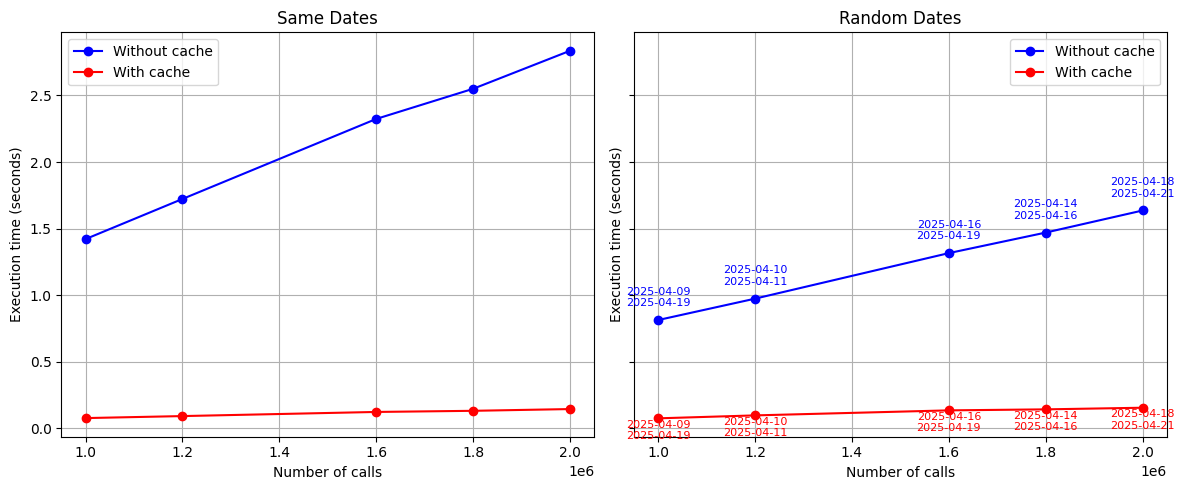

In [6]:
calls: list[int] = [1000000, 1200000, 1600000, 1800000, 2000000]

date_start, date_end = datetime(2025, 4, 1), datetime(2025, 4, 22, 9, 10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

compare_execution_times_with_and_without_cache(ax1, calls, get_logs_between, get_logs_between_cache, date_start, date_end)
compare_execution_times_with_and_without_cache(ax2, calls, get_logs_between, get_logs_between_cache, date_start, date_end, randomize=True)

ax1.set_title("Same Dates")
ax2.set_title("Random Dates")

plt.tight_layout()
plt.show()

Se puede observar en las gráficas que, en ambos escenarios (uso de las mismas fechas y fechas aleatorias), la función sin almacenamiento en caché presenta un comportamiento lineal O(n), incrementando su tiempo de ejecución a medida que aumenta el número de llamadas. En contraste, al almacenar los resultados en caché, la función muestra un comportamiento casi constante O(1), manteniéndose eficiente independientemente del número de llamadas realizadas.

‼️IMPORTANTE

Hay que tener en cuenta que al utilizar caché estamos mejorando el rendimiento en términos de tiempo de ejecución, pero aumentando el uso de memoria (empeorando el algoritmo en cuanto a complejidad espacial se refiere).
En la implementación original sin caché, la complejidad espacial del algoritmo es de O(n), donde n representa la cantidad de logs retornados por cada consulta.

Con la nueva implementación basada en `lru_cache`, se almacenan en memoria todas las combinaciones únicas de rangos de fechas consultados.
Esto implica que la complejidad espacial total del sistema pasa a ser O(m * n), donde:

n es el número promedio de logs por rango consultado

m es la cantidad de rangos de fechas distintos que se han consultado